In [1]:
import cv2
from pathlib import Path
from random import *
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import hog
from imutils import face_utils
#import dlib
import os
import pickle
np.random.seed(1000)


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
frames = []
labels = []
for file in os.listdir('output/'):
    if file[-13:] == 'frames.pickle':
        with open('output/'+file, 'rb') as f:
            frames.append(pickle.load(f))
    elif file[-13:] == 'labels.pickle':
        with open('output/'+file, 'rb') as f:
            labels.append(pickle.load(f))

In [4]:
print(len(frames), len(labels))

8231 8231


In [5]:
from sklearn.model_selection import train_test_split
train_clips, test_clips, train_clips_labels, test_clips_labels = \
    train_test_split(frames, labels, test_size=0.2, random_state=42)

In [6]:
train_images, test_images, train_labels, test_labels = [], [], [], []

for clip, label in zip(train_clips, train_clips_labels):
    try:
        train_images, train_labels = train_images + clip, train_labels + [label[0]] * len(clip)
    except Exception as e:
        continue

for clip, label in zip(test_clips, test_clips_labels):
    try:
        test_images, test_labels = test_images + clip, test_labels + [label[0]] * len(clip)
    except Exception as e:
        continue
    
print(len(train_images), len(train_labels), len(test_images), len(test_labels))

1974773 1974773 493987 493987


In [7]:
train_images, test_images, train_labels, test_labels = np.asarray(train_images), np.asarray(test_images), np.asarray(train_labels), np.asarray(test_labels)

In [8]:
test_images, test_labels =np.asarray(test_images), np.asarray(test_labels)

In [9]:
test_images = np.expand_dims(test_images, axis=3)
train_images = np.expand_dims(train_images, axis=3)

In [43]:
import tensorflow.keras.layers as kl
import tensorflow.keras.losses
from tensorflow.keras.applications.resnet50 import ResNet50

In [78]:
def network():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(48, 48, 1)))
    # First conv block
    model.add(kl.Conv2D(filters = 96, kernel_size=7, padding='same', strides=2))
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(3, 3)))
    # Second conv block
    model.add(kl.Conv2D(filters = 144, kernel_size=5, padding='same', strides=1))
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    # Third-Fourth-Fifth conv block
    for i in range(3):
        model.add(kl.Conv2D(filters = 144, kernel_size=3, padding='same', strides=1))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(kl.MaxPooling2D(pool_size=(3, 3)))
    # Flatten
    model.add(kl.Flatten())
    # First FC 
    model.add(kl.Dense(4048))
    # Second Fc
    model.add(kl.Dense(4048))
    # Third FC
    model.add(kl.Dense(18, activation='sigmoid'))
    
    return model

In [79]:
model = network()
InitialLearnRate = 0.03
MaxEpochs = 30
MiniBatchSize = 32
opt = tf.keras.optimizers.SGD(lr=InitialLearnRate, decay=InitialLearnRate / MaxEpochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


In [83]:
model.fit(train_images, train_labels, epochs=2, batch_size=50)

Train on 1974773 samples
Epoch 1/2
1974773/1974773 [==============================] - 271s 137us/sample - loss: 0.3220 - accuracy: 0.8692
Epoch 2/2
1974773/1974773 [==============================] - 267s 135us/sample - loss: 0.3190 - accuracy: 0.8709


In [84]:
test_loss, test_acc = model.evaluate(test_images,  test_labels)

493987/493987 [==============================] - 34s 68us/sample - loss: 0.3878 - accuracy: 0.8768


In [3]:
model = keras.models.load_model('AUs.h5')

(1, 48, 48, 1)
(1, 48, 48, 1)
(1, 48, 48, 1)
(1, 48, 48, 1)
(1, 48, 48, 1)
(1, 48, 48, 1)


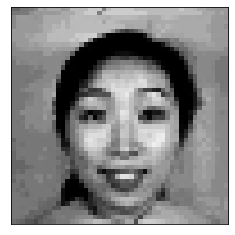

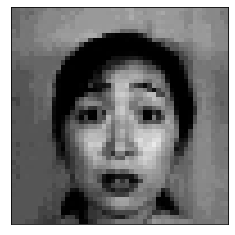

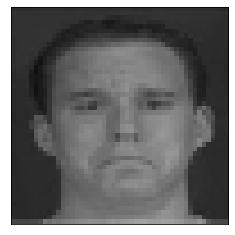

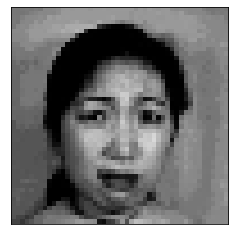

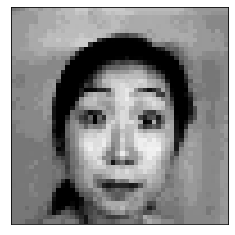

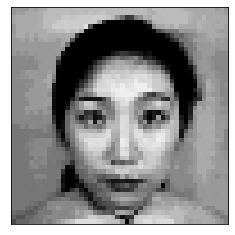

In [23]:
def removePlotterAxes():
    plt.figure()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pass
def plotImg(img):
    removePlotterAxes()
    plt.imshow(img)
    pass
samples = []
samples_dir = os.listdir("sample")
for frame_img in samples_dir:
    image = cv2.imread(f'sample\\{frame_img}')
    samples.append(cv2.cvtColor(cv2.resize(image,(48,48)), cv2.COLOR_BGR2GRAY))
    
samples = np.asarray(samples)
prediction = []
for sample in samples:
    plotImg(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
    prd = np.expand_dims(sample, axis=-1)
    prd = np.expand_dims(prd, axis=0)
    print(prd.shape)
    prediction.append(model.predict(prd)[0])

In [87]:
y = np.array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
prediction = np.asarray(prediction)
imp_au = []
for x in prediction:
    temp = [x[i] for i in [1,2,3,5,8,10]]
    imp_au.append(temp)
print(imp_au)
imp_au = np.asarray(imp_au)
for x in prediction:
    z=x@y
    a=np.linalg.norm(x)*np.linalg.norm(y)
    #print(x)
    _1=100+(((x[1]+x[3]+x[8])/3)-((x[2]+x[5]+x[10])/3)*100)
    _2=(((z/a)+1)*50)
    print(_1, _2, (_1+_2)/2,'\n')
print("_______________________")
y = [0,1,0,1,0,1]
for x in imp_au:
    z=x@y
    a=np.linalg.norm(x)*np.linalg.norm(y)
    #print(x)
    _1=100+(((x[0]+x[2]+x[3])/3)-((x[1]+x[3]+x[4])/3)*100)
    _2=(((z/a)+1)*50)
    print(_1, _2, (_1+_2)/2,'\n')

[[0.30476734, 0.38425845, 0.5201645, 0.42473766, 0.34353533, 0.22729826], [0.30073538, 0.32752708, 0.56404513, 0.45186228, 0.54174244, 0.23762438], [0.29348475, 0.49759147, 0.40122238, 0.5808583, 0.32497644, 0.2091327], [0.27749076, 0.30822733, 0.59176207, 0.4112595, 0.5063877, 0.20962445], [0.2563825, 0.3735896, 0.51503086, 0.5626083, 0.6017278, 0.19031624], [0.25578958, 0.22587459, 0.61044157, 0.2920865, 0.3577518, 0.19368416]]
65.8463443517685 89.42192801975345 77.63413618576098 

66.56838138898215 88.5140989111207 77.54124015005142 

57.42048128445943 88.70371862868835 73.06209995657389 

69.4881701072057 87.32883300925836 78.40850155823203 

62.90724444389344 86.43489244966003 74.67106844677673 

76.68648612499237 86.9427786487812 81.81463238688679 

_______________________
61.99884366989135 82.23610368328691 72.11747367658913 

56.4011534055074 78.38218552068732 67.39166946309736 

53.64431611696879 87.51887324151366 70.58159467924122 

59.56435267130534 76.9332354947039 68.24879